<a href="https://colab.research.google.com/github/chrismartel/COMP551/blob/marie_dev/projects/p2/diabetes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mini-Project 2: Optimization and Text Classification**

## Project Setup


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd ~/.ssh/
!ssh-keygen -t rsa -b 4096
!ssh-keyscan -t rsa github.com >> ~/.ssh/known_hosts
%cd /root/.ssh
!cat id_rsa.pub
# then, copy key to github account

In [ ]:
%cd /content/drive/MyDrive/git/COMP551/projects/p2

/content/drive/MyDrive/git/COMP551/projects/p2


In [ ]:
import pandas as pd
import numpy as np
import time
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from random import randint
np.random.seed(1234)

In [ ]:
!git status

## PART I: Optimization


### Import Data

In [41]:
train_df, test_df, val_df = pd.read_csv('data/diabetes/diabetes_train.csv'), pd.read_csv('data/diabetes/diabetes_test.csv'),pd.read_csv('data/diabetes/diabetes_val.csv')
x_train, y_train = train_df.iloc[:,:-1].to_numpy(), train_df.iloc[:,-1].to_numpy()
x_test, y_test = test_df.iloc[:,:-1].to_numpy(), test_df.iloc[:,-1].to_numpy()
x_val, y_val = val_df.iloc[:,:-1].to_numpy(), val_df.iloc[:,-1].to_numpy()

### 1. Logisitic regression, learning rate and number of training iterations
You should first start by running the logistic regression code using the given implementation. This will serve
as a baseline for the following steps. Find a learning rate and a number of training iterations such that the
model has fully converged to a solution. Make sure to provide empirical evidence supporting your decision (e.g.
training and validation accuracy as a function of number of training iterations).

#### 1.1 Logistic Regression
We leverage the Logisitic Regression notebook which can be found here: 

https://github.com/mravanba/comp551-notebooks/blob/master/LogisticRegression.ipynb


The Logisitic Regression class is modified to allow for stochastic gradient and momentum. 

In [40]:
logistic = lambda z: 1./ (1 + np.exp(-z))   #logistic function

class LogisticRegression:
    
    def __init__(self, add_bias=True, learning_rate=.1, epsilon=1e-4, max_iters=1e5, verbose=False, batch_size=None, momentum=False, momentum_coefficient=0.9):
        self.add_bias = add_bias
        self.learning_rate = learning_rate
        self.epsilon = epsilon                        #to get the tolerance for the norm of gradients 
        self.max_iters = max_iters                    #maximum number of iteration of gradient descent
        self.verbose = verbose
        self.gradient_norm = np.inf
        self.batch_size = batch_size
        self.momentum = momentum

        if self.momentum:
          # array to store gradient of each time step
          self.gradients = [0] * max_iters
          self.momentum_coefficient = momentum_coefficient

    def fit(self, x, y):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        self.w = np.zeros(D)
        # gradient
        g = np.inf 
        # timestamp
        t = 0
        # the code snippet below is for gradient descent
        while self.gradient_norm > self.epsilon and t < self.max_iters:
            g = self.stochastic_gradient(x, y, self.batch_size)

            if self.momentum:
              self.gradients[t] = g

            self.gradient_norm = np.linalg.norm(g)

            if self.momentum and t != 0:
              self.w = self.w -self.learning_rate * self.running_average(t)
            else:
              self.w = self.w - self.learning_rate * g 

            t += 1
        
        if self.verbose:
            print(f'terminated after {t} iterations, with norm of the gradient equal to {np.linalg.norm(g)}')
            print(f'the weight found: {self.w}')
        return self
    
    def predict(self, x):
        if x.ndim == 1:
            x = x[:, None]
        Nt = x.shape[0]
        if self.add_bias:
            x = np.column_stack([x,np.ones(Nt)])
        yh = logistic(np.dot(x,self.w))            #predict output
        return yh

    def gradient(self, x, y):
        N,D = x.shape
        yh = logistic(np.dot(x, self.w))   # predictions  size N
        grad = np.dot(x.T, yh - y)/N        # divide by N because cost is mean over N points
        return grad

    def stochastic_gradient(self, x, y, batch_size=None):
        N = x.shape[0]
        if batch_size is None or batch_size > N:              # gradient on full data by default
          batch_size = N
        inds = np.random.permutation(N)
        x_batch = x[inds,:][:batch_size,:]
        y_batch = y[inds][:batch_size]
        yh = logistic(np.dot(x_batch, self.w))
        stoch_grad = np.dot(x_batch.T,yh - y_batch)/batch_size
        return stoch_grad

    def running_average(self, t):
      running_average = 0
      for i in range(1,t+1):
          running_average += (self.momentum_coefficient ** (t-i)) * (1-self.momentum_coefficient) * self.gradients[i]
      return running_average


#### 1.2 Cost Function

In [39]:
def cost_fn(y, yh):
    return y[y != yh].size/y.size

#### 1.3 Gradient Descent Hyper-Parameter Tuning

Method used to visualize the training and validation accuracy convergence/divergence when increasing the maximum number of gradient descent iterations for different learning rates.

In [42]:
def gd_hypertuning_plots(param_range_type='lr', param_range=None, max_iters_range=np.arange(0,100,1), x_train=None, y_train=None, x_val=None, y_val=None, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None):
  '''
  param_range_type: the code of the parameter we want to tune. 
                    'lr': learning rate
                    'bs': batch size
                    'mc': momentum coefficient

  param_range: the range of the param we want to tune

  max_iters_range: the rage of number of gradient descent iterations

  x_train, y_train, x_val, y_val: the data

  reg_type: type of regression to use

  lr: fixed learning rate to use when tuning other parameters

  batch_size: fixed batch size to use when tuning other parameters

  momentum: indicates if momentum gradient descent is used 

  momentum_coefficient: fixed momentum coefficient to use when tuning other parameters
  '''
  
  # setup figures and axis
  figure, axis = plt.subplots(4, 1)
  figure.set_figheight(10)
  figure.set_figwidth(10)
  figure.tight_layout(pad=5.0)

  # figure title
  if param_range_type == 'lr':
    param_name = 'Learning Rates'
  elif param_range_type == 'bs':
    param_name = 'Batch Sizes'
  elif param_range_type == 'mc':
    param_name = 'Momentum Coefficients'

  figure.suptitle('Convergence of Gradient Descent Solution for Different {param}'.format(param=param_name), fontsize=16)
  axis[0].set_title("Train Accuracy")
  axis[0].set_ylabel("Accuracy")

  axis[1].set_title("Validation Accuracy")
  axis[1].set_ylabel("Accuracy")

  axis[2].set_title("Gradient Norm")
  axis[2].set_ylabel("Gradient Norm")

  axis[3].set_title("Execution Time")
  axis[3].set_ylabel("Time")


  for i,  param in enumerate(param_range):
    
    # setup param we want to tune
    if param_range_type == 'lr':
      lr = param
    elif param_range_type == 'bs':
      batch_size = param
    elif param_range_type == 'mc':
      momentum_coefficient = param

    # y axis ranges
    acc_train_arr = np.zeros((max_iters_range.size))
    acc_val_arr = np.zeros((max_iters_range.size))
    g_norm_arr = np.zeros((max_iters_range.size))
    time_arr = np.zeros((max_iters_range.size))

    for j, max_iters in enumerate(max_iters_range):
      t0 = time.time()
      if reg_type == 'logistic':
        reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=1e-4, max_iters=max_iters, verbose=False, batch_size=batch_size, momentum=momentum, momentum_coefficient=momentum_coefficient)
      reg.fit(x_train, y_train)

      # compute error
      yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
      t1 = time.time()
      time_arr[j] = t1 - t0
      y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
      acc_train_arr[j], acc_val_arr[j] = 1 - cost_fn(y_pred_train, y_train), 1 - cost_fn(y_pred_val, y_val)
      g_norm_arr[j] = reg.gradient_norm

    # add plot lines
    axis[0].plot(max_iters_range, acc_train_arr, label="%0.6f" % param)
    axis[1].plot(max_iters_range, acc_val_arr, label="%0.6f" % param)
    axis[2].plot(max_iters_range, g_norm_arr, label="%0.6f" % param)
    axis[3].plot(max_iters_range, time_arr, label="%0.6f" % param)

  for i, subplot in enumerate(axis):
    subplot.set_xlabel("Number of Iterations")
    subplot.legend()
  plt.show()



#### 1.4 Learning Rate and Number of Iterations Tuning

The learning rate and the max number of iterations are determined empirically. We start with high learning rates. The accuracy per number of iterations will be plot for each learning rate. If we see that the accuracy oscillates and does not converge to a value, it means that our learning is too high.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.


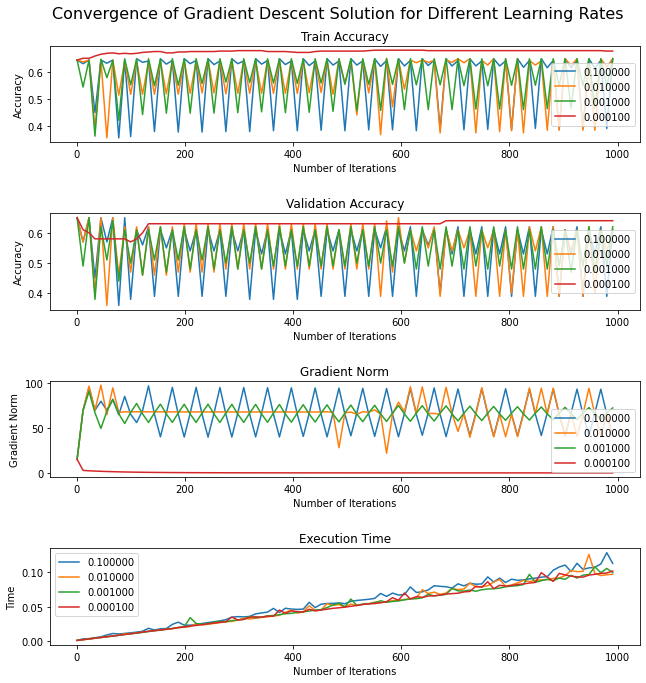

In [49]:
lr_range = np.array([0.1,0.01,0.001,0.0001])
max_iters_range = np.arange(1,1000,11)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

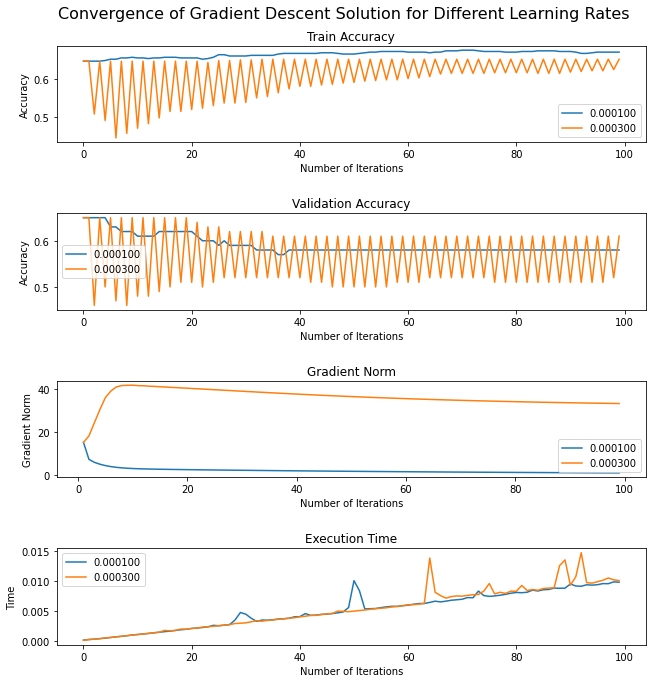

In [44]:
lr_range = np.array([0.0001,0.0003])
max_iters_range = np.arange(0,100,1)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

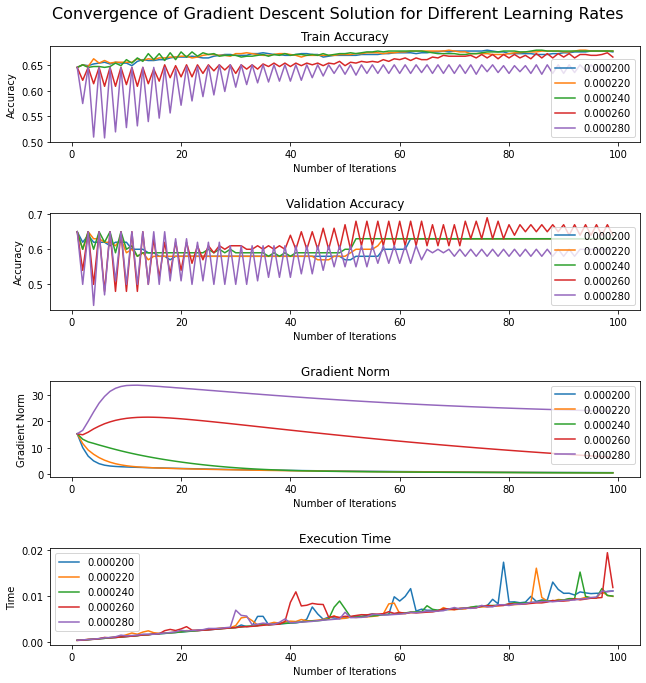

In [45]:
lr_range = np.array([0.0002, 0.00022, 0.00024, 0.00026,0.00028])
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

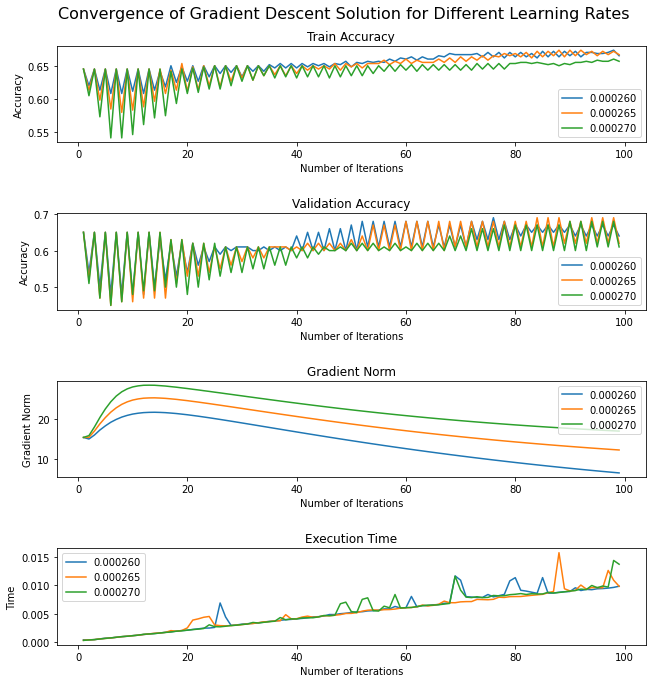

In [46]:
lr_range = np.array([0.00026,0.000265, 0.00027])
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

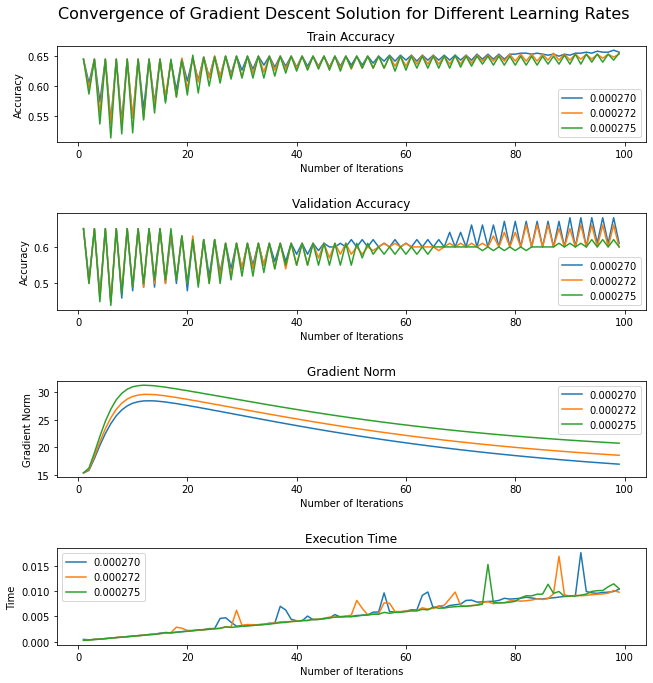

In [47]:
lr_range = np.array([0.00027,.000272, 0.000275])
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'lr', param_range = lr_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=0.001, batch_size=None, momentum=False, momentum_coefficient=None)

#### 1.5 Results

From the empirically testing, we decided to use a learning rate of 0.000271 and a maximum number of iterations of 3 000 000.

In [48]:
lr = 0.000270
max_iters = 1000
epsilon = 0.0001

reg = LogisticRegression(add_bias=True, learning_rate=lr, epsilon=epsilon, max_iters=max_iters, verbose=True)
reg.fit(x_train, y_train)

# compute error
yh_train, yh_val = reg.predict(x_train), reg.predict(x_val)
y_pred_train, y_pred_val = np.rint(yh_train), np.rint(yh_val)
acc_train, acc_val = 1 - cost_fn(y_pred_train, y_train), 1 - cost_fn(y_pred_val, y_val)

print("train accuracy: {acc_train}".format(acc_train=acc_train))
print("validation accuracy: {acc_val}".format(acc_val=acc_val))

terminated after 1000 iterations, with norm of the gradient equal to 12.263188795916802
the weight found: [ 0.04841348  0.01370009 -0.03049161 -0.00106901  0.00269185 -0.00588578
  0.00149334  0.00181675 -0.00995664]
train accuracy: 0.6716666666666666
validation accuracy: 0.6799999999999999


### 2. Mini-batch Sochastic Gradient
Implement mini-batch stochastic gradient descent. Then, using growing minibatch sizes (e.g. 8, 16, 32, ...) compare the convergence speed and the quality of the final solution to the fully batched baseline. What configuration
works the best among the ones you tried ?


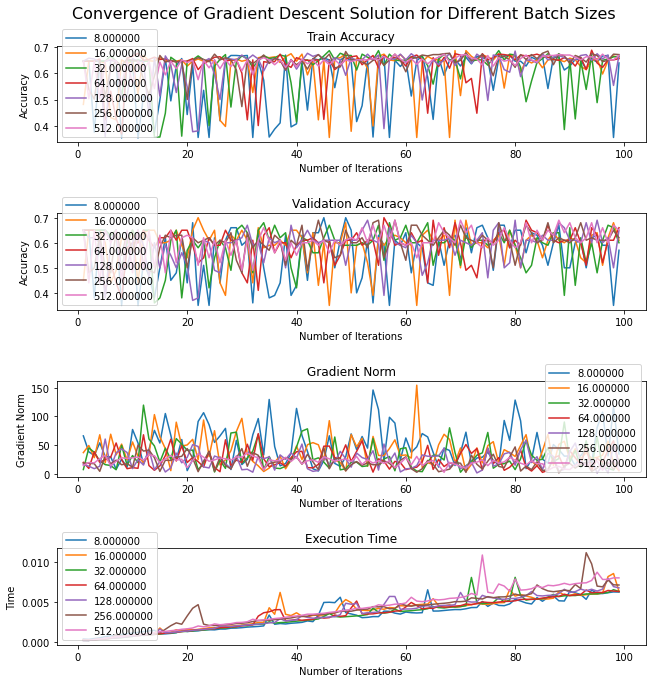

In [ ]:
batch_size_range = [8, 16, 32, 64, 128, 256, 512]

max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'bs', param_range = batch_size_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=None, momentum=False, momentum_coefficient=None)

### 3. Gradient Descent with Momentum
Add momentum to the gradient descent implementation. 
Trying multiple values for the momentum coefficient, how does it compare to regular gradient descent ? 
Specifically, analyze the impact of momentum on the convergence speed and the quality of the final solution.


Vary the momentum coefficient and check effect on convergence speed. 

No batch size --> full data

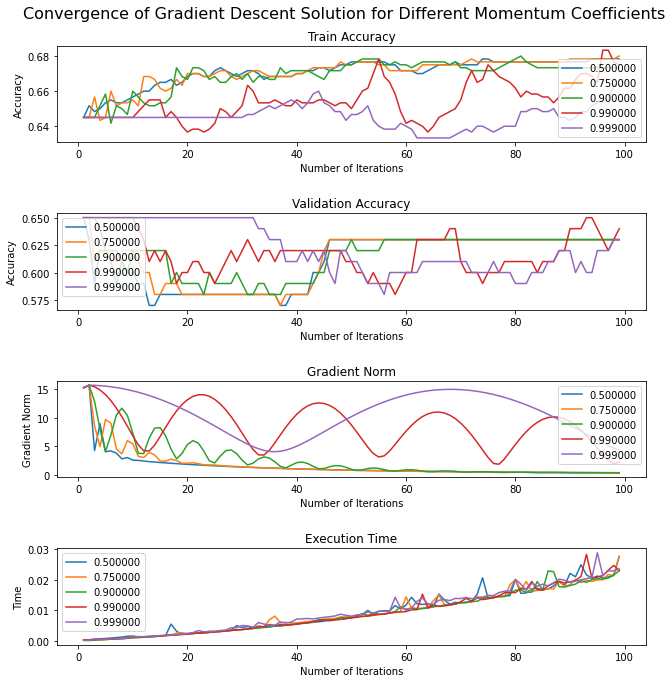

In [ ]:
momentum_coefficient_range = [0.5, 0.75, 0.9, 0.99, 0.999]
max_iters_range = np.arange(1,100,1)
gd_hypertuning_plots(param_range_type = 'mc', param_range = momentum_coefficient_range, max_iters_range=max_iters_range, x_train=x_train, y_train=y_train, x_val=x_val, y_val=y_val, reg_type='logistic', lr=lr, batch_size=None, momentum=True, momentum_coefficient=None)

### 4. Repeat the previous step for a) the smallest batch size and b) largest batch size you tried in 2). 
In which setting (small mini-batch, large mini-batch, fully batched) is it the most / least effective ?

#### 4.1 Gradient Descent with Momentum using smallest batch size

#### 4.2 Gradient Descent with Momentum using largest batch size from 2. 

#### 4.3 Results and Discussion

## PART II: Text Classification
